In [1]:
# Import Modules
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

# Allow Multiple Output per Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# StatsModels for Ordinary Least Squares Regresssion
import statsmodels.api as sm

# Import the adfuller (ADF) Stationarity Test
from statsmodels.tsa.stattools import adfuller

# Import QuantStats for Trading Strategy Tear-Sheets
import quantstats as qs

In [2]:
# Market Data

# Yahoo Finance - Equity Pairs
# ----------------------------------------
# Code vs Pepsi:                ['KO', 'PEP']
# Microsoft vs Google:          ['MSFT','GOOG']
# Apple vs Amazon:              ['AAPL','AMZN']
# Ford vs GM:                   ['F', 'GM']
# United- vs Delta Air:         ['UAL', 'DAL']
# Cisco vs Juniper:             ['CSCO', 'JNPR']
# ExxonMibil vs Chevron:        ['XOM', 'CVX']
# Australia vs Canada Equities: ['EWA', 'EWC']

tickers = ['EWA', 'EWC']

start = '2021-01-01'
end= '2025-06-01'

# Create DataFrame
df = pd.DataFrame(columns=tickers)

# Download Adjusted Close Prices from Yahoo Finance!
df[tickers[0]] = yf.download(tickers[0], start, end, progress=False)['Close']
df[tickers[1]] = yf.download(tickers[1], start, end, progress=False)['Close']

# Display DataFrame
df.head()

,EWA,EWC
Date,,
2021-01-04,19.897627,28.183235
2021-01-05,20.179159,28.711554
2021-01-06,20.452406,28.975712
2021-01-07,20.460688,29.285425
2021-01-08,20.560053,29.248983


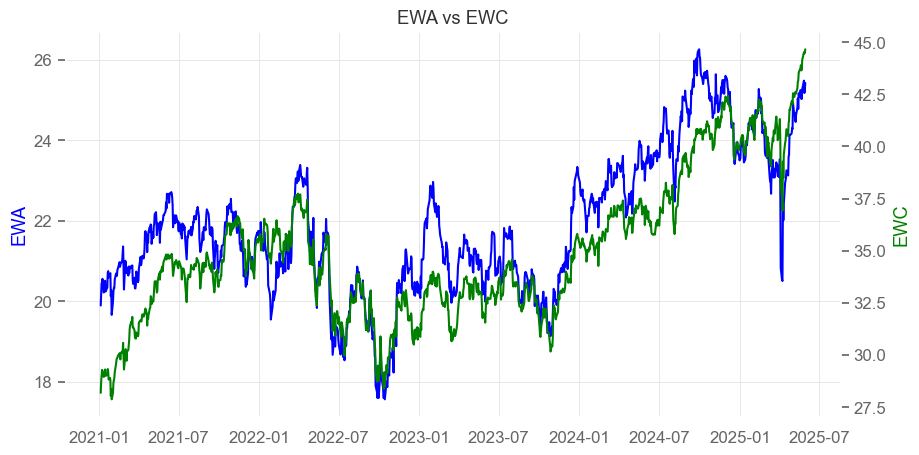

In [3]:
# Plot Market Data
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df[tickers[0]], color='blue')
plt.ylabel(tickers[0], color='blue')
ax1 = ax.twinx()
ax1.plot(df.index, df[tickers[1]], color='green')
plt.ylabel(tickers[1], color='green')
plt.grid()
plt.title(f'{tickers[0]} vs {tickers[1]}')
plt.show();

In [4]:
# Uncomment to Display Market Data
#df.head()

In [5]:
# Compute the Beta or hedge ratio between Y (Google) and X (S&P 500 Index)
Y = df[tickers[0]]
x = df[tickers[1]]

# Add Constant Intercept Term
X = sm.add_constant(x)

# Peform OLS
result = sm.OLS(Y,X).fit()

# Uncomment to View Summary
#result.summary()

# Beta or Hedge Ratio
hedge_ratio = result.params[1]
print(f'Hedge Ratio: {hedge_ratio:.4f}')

Hedge Ratio: 0.4564


In [6]:
# Compute the Spread
df['spread'] = Y - hedge_ratio * x

# Also Compute the Spread Log Return
df['log_return'] = np.log(df['spread']/df['spread'].shift(1))

# Uncomment to Display the Spread Data Frame
#df.head()

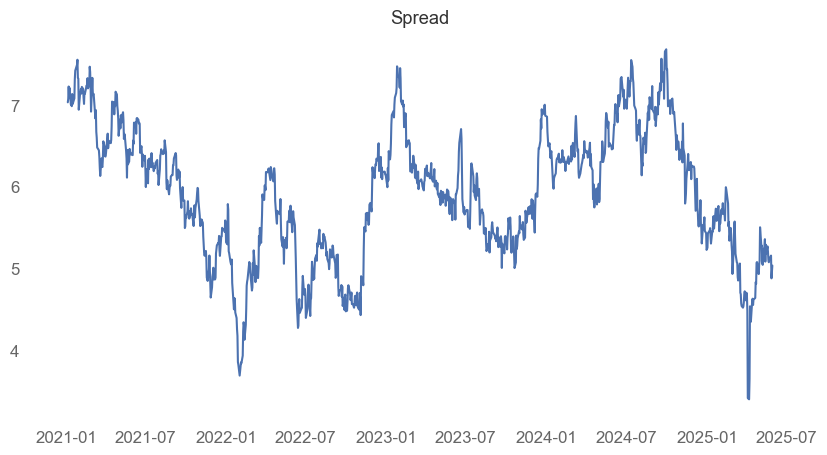

In [7]:
# Plot the Spread
fig = plt.figure(figsize=(10,5))
plt.plot(df['spread'])
plt.grid()
plt.title('Spread')
plt.show();

#### Test for Co-Integration or Stationarity

In [8]:
# Test the Spread for Stationarity using ADF
adf = adfuller(df['spread'], maxlag=1)

# p-value
p_value = adf[1]

# Print ADF Results
print(f'ADF Result Parameters \n{adf}\n')

# Print Test Statistic
print(f'Test Statistic: {adf[0]:.4f}')

# Print Critical Value 
print(f'Critical Value: {adf[4]["5%"]:.4f}')

# Print P-Value
print(f'P-Value: {adf[1]*100:.4f}%')

ADF Result Parameters 
(-3.018506967370675, 0.03320185690977243, 1, 1105, {'1%': -3.4362817248910282, '5%': -2.8641591533631945, '10%': -2.5681645177207675}, -1022.4936380623935)

Test Statistic: -3.0185
Critical Value: -2.8642
P-Value: 3.3202%


In [9]:
# Method to Print Stationarity Result
def is_stationary(p_value):
    if (p_value<0.05):
        print(f'Series is Stationary (p-value {p_value*100:.4f}%)') 
    else:
        print(f'Series NOT Stationary (p-value {p_value*100:.4f}%)') 
    return

# Display Stationarity Result
is_stationary(p_value)

Series is Stationary (p-value 3.3202%)


In [10]:
# Method to check if a series is stationary
def is_series_stationary(series):
    adf = adfuller(series, maxlag=1)   # Test the Spread for Stationarity using ADF
    p_value = adf[1]                   # p-value
    return is_stationary(p_value)

#### Compute Z-Score
We compute the normalized z-score as follows:  
  
Z-Score $ = \left( \frac{x-\mu}{\sigma} \right) $
  

In [11]:
# Compute Mean and Std using window specified
window = 60
df['mean'] = df['spread'].ewm(span=window).mean()
df['std'] = df['spread'].ewm(span=window).std()

# Drop NaN Values
df.dropna(inplace=True)

# Compute the Z-Score
df['z_score'] = ( df['spread'] - df['mean'] ) / df['std']

# Z-Score Boundaries
df['z_up'] = 2.0
df['z_down'] = -2.0

# Uncomment to Display DataFrame
#df.head()

#### Trading Signals

In [12]:
# Long Trading Signals
long_entry = (df['z_score'] <= df['z_down'])
long_exit = (df['z_score'] >= 0)

# Initialize Long Position Column to NaN
df['long_pos'] = np.nan

# Apply Long Trading Signals
df.loc[long_entry, 'long_pos'] = 1
df.loc[long_exit, 'long_pos'] = 0

# Forward Fill NaN Values
df['long_pos'].fillna(method='ffill', inplace=True)

# Fill any remaining NaN values wth Zero
df['long_pos'].fillna(0, inplace=True)

In [13]:
# Short Trading Signals
short_entry = (df['z_score'] >= df['z_up'])
short_exit = (df['z_score'] <= 0)

# Initialize Short Position Column to NaN
df['short_pos'] = np.nan

# Apply Long Trading Signals
df.loc[short_entry, 'short_pos'] = -1
df.loc[short_exit, 'short_pos'] = 0

# Forward Fill NaN Values
df['short_pos'].fillna(method='ffill', inplace=True)

# Fill any remaining NaN values wth Zero
df['short_pos'].fillna(0, inplace=True)

In [14]:
# Total Trading Position
df['total_pos'] = df['long_pos'] + df['short_pos']

# Uncomment to Display DataFrame
#df.head()

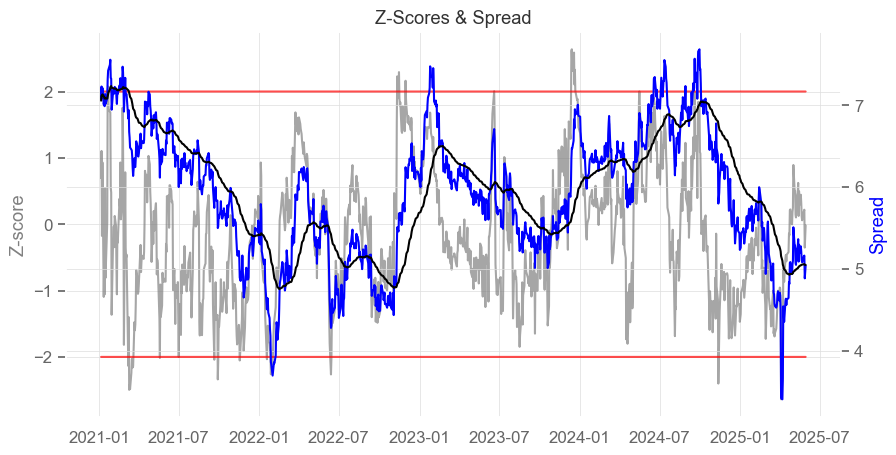

In [15]:
# Plot the Z-Scores
fig, ax = plt.subplots(figsize=(10,5))

# first axis
ax.plot(df.index, df['z_score'], color='grey', alpha=0.7)
ax.plot(df.index, df['z_up'], color='red', alpha=0.7)
ax.plot(df.index, df['z_down'], color='red', alpha=0.7)
ax.set_ylabel('Z-score', color='grey')

# second axis
ax1 = ax.twinx()
ax1.plot(df.index, df['spread'], color='blue')
ax1.plot(df.index, df['mean'], color='black')
ax1.set_ylabel('Spread', color='blue')

plt.title('Z-Scores & Spread')
plt.show();

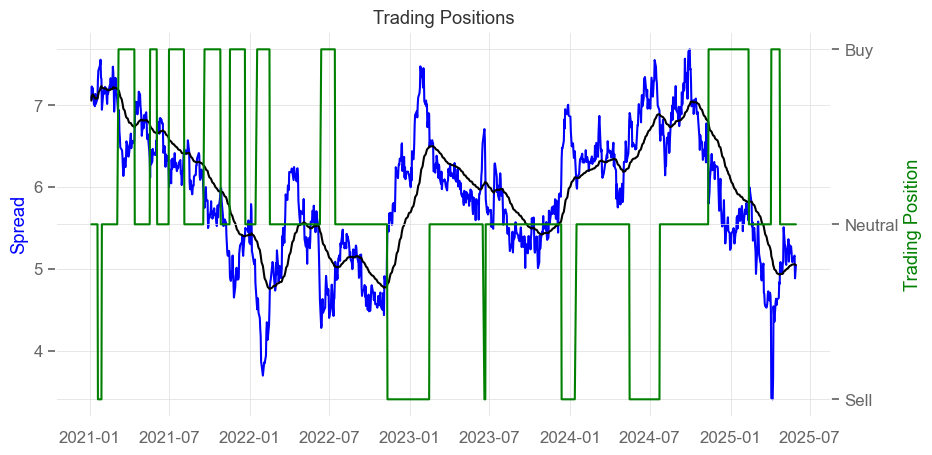

In [16]:
# Plot Trading Positions
fig, ax = plt.subplots(figsize=(10,5))

# first axis
plt.plot(df.index, df['spread'], color='blue')
plt.plot(df.index, df['mean'], color='black')
plt.ylabel('Spread', color='blue')

# second axis
ax1 = ax.twinx()
ax1.plot(df.index, df['total_pos'], color='green')
ax1.set_ylabel('Trading Position', color='green')
ax1.set_yticks([-1, 0, 1])
ax1.set_yticklabels(['Sell','Neutral','Buy'])

plt.title('Trading Positions')
plt.show();

#### Performance

In [17]:
# Compute Strategy Returns - Shift Position by 1 Day to mitigate look-ahead bias
df['strategy_returns'] = df['total_pos'].shift(1) * df['log_return']
strategy_mean = df['strategy_returns'].mean()
strategy_std = df['strategy_returns'].std()

# Compute the Sharpe Ratio
risk_free_rate = 0.05 # assume 5.0% per year

# Daily Sharpe Ratio
# Note: we convert risk-free rate to a daily rate i.e. divide by 252
sharpe_daily = (strategy_mean - (risk_free_rate/252) ) / strategy_std
print(f'Daily Sharpe Ratio: {sharpe_daily:.4f}')

# Annualized Sharpe Ratio
# Scale daily by t/sqrt(t) = sqrt(t) i.e. sqrt(252)
sharpe_annual = sharpe_daily * np.sqrt(252)
print(f'Annual Sharpe Ratio: {sharpe_annual:.4f}')

# Is Spread Data Series Stationary?
is_spread_stationary = is_series_stationary(df['spread'])

Daily Sharpe Ratio: 0.0478
Annual Sharpe Ratio: 0.7586
Series is Stationary (p-value 2.9071%)


                    Strategy
------------------  ----------
Start Period        2021-01-06
End Period          2025-05-30
Risk-Free Rate      5.0%
Time in Market      34.0%

Cumulative Return   154.8%
CAGR﹪              15.82%

Sharpe              0.76
Prob. Sharpe Ratio  63.78%
Sortino             1.28
Sortino/√2          0.9
Omega               1.25

Max Drawdown        -28.0%
Longest DD Days     550

Gain/Pain Ratio     0.33
Gain/Pain (1M)      1.18

Payoff Ratio        1.16
Profit Factor       1.33
Common Sense Ratio  1.59
CPC Index           0.83
Tail Ratio          1.19
Outlier Win Ratio   12.23
Outlier Loss Ratio  2.23

MTD                 0.0%
3M                  44.39%
6M                  32.85%
YTD                 60.49%
1Y                  37.51%
3Y (ann.)           11.04%
5Y (ann.)           15.82%
10Y (ann.)          15.82%
All-time (ann.)     15.82%

Avg. Drawdown       -6.48%
Avg. Drawdown Days  45
Recovery Factor     3.85
Ulcer Index         0.08
Serenity Index      1.2

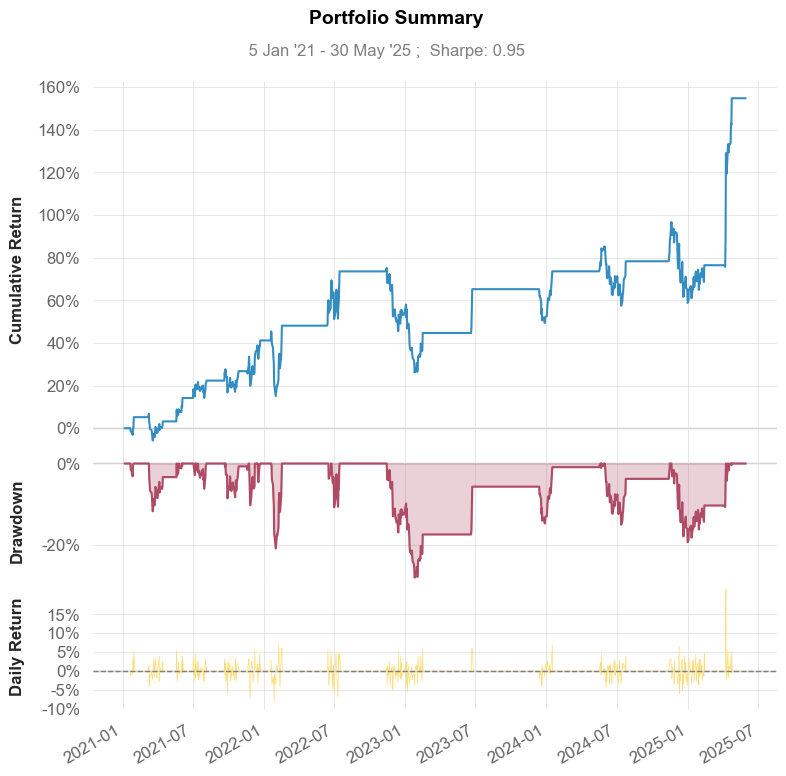

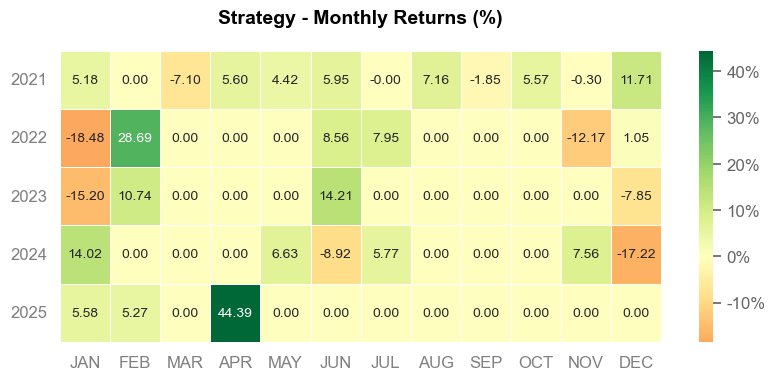

In [18]:
# QuantStats Tearsheet
qs.reports.basic(df['strategy_returns'], rf = risk_free_rate)